# Wikipediaから学習したWord2Vecモデルを使用して、マッチング処理を行う

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sudachipy import dictionary, tokenizer
from tqdm import tqdm

## Wikipedia学習Word2Vecモデルの読み込み

In [2]:
model_path = "../models/word2vec_wiki40b_full.wordvectors"
word_vectors = KeyedVectors.load(model_path, mmap="r")

print(f"語彙数: {len(word_vectors):,}語")
print(f"ベクトル次元数: {word_vectors.vector_size}")

語彙数: 393,381語
ベクトル次元数: 300


## データの読み込み

In [3]:
project_df = pd.read_csv("../data/raw/project.csv")
print(f"プロジェクトデータ: {len(project_df)}件")

user_df = pd.read_csv("../data/raw/user_work_histories.csv")
print(f"ユーザー職歴データ: {len(user_df)}件")
print(f"ユニークユーザー数: {user_df['user_id'].nunique()}名")

プロジェクトデータ: 1000件
ユーザー職歴データ: 911件
ユニークユーザー数: 300名


## テキスト処理関数

In [4]:
def extract_nouns(text: str) -> list[str]:
    if pd.isna(text):
        return []

    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    mode = tokenizer.Tokenizer.SplitMode.C
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns

### ドキュメントベクトル作成関数

In [5]:
def create_document_vector(text: str, word_vectors: KeyedVectors) -> np.ndarray:
    nouns = extract_nouns(text)

    vectors = []
    for noun in nouns:
        if noun in word_vectors:
            vectors.append(word_vectors[noun])

    if len(vectors) == 0:
        return np.zeros(word_vectors.vector_size)

    return np.mean(vectors, axis=0)

## プロジェクトベクトルの作成

In [6]:
def create_project_vectors(
    project_df: pd.DataFrame, word_vectors: KeyedVectors
) -> np.ndarray:
    project_vectors = []

    for idx, row in tqdm(
        project_df.iterrows(), total=len(project_df), desc="プロジェクトベクトル作成"
    ):
        combined_text = f"{row['name']} {row['description']} {row['desired_role']}"
        doc_vector = create_document_vector(combined_text, word_vectors)
        project_vectors.append(doc_vector)

    return np.array(project_vectors)


project_vectors = create_project_vectors(project_df, word_vectors)
print("プロジェクトベクトルを作成しました")
print(f"形状: {project_vectors.shape}")

プロジェクトベクトル作成: 100%|██████████| 1000/1000 [00:12<00:00, 80.90it/s]

プロジェクトベクトルを作成しました
形状: (1000, 300)


## ユーザープロファイルベクトルの作成

In [7]:
def create_user_profile_vectors(
    user_df: pd.DataFrame, word_vectors: KeyedVectors
) -> tuple[np.ndarray, list[int]]:
    grouped = user_df.groupby("user_id")

    user_vectors = []
    user_ids = []

    for user_id, group in tqdm(grouped, desc="ユーザープロファイル作成"):
        all_texts = []
        for _, row in group.iterrows():
            combined_text = f"{row['project_name']} {row['description']} {row['role']}"
            all_texts.append(combined_text)

        user_text = " ".join(all_texts)
        user_vector = create_document_vector(user_text, word_vectors)

        user_vectors.append(user_vector)
        user_ids.append(user_id)

    return np.array(user_vectors), user_ids


user_vectors, user_ids = create_user_profile_vectors(user_df, word_vectors)
print("ユーザープロファイルベクトルを作成しました")
print(f"ユーザー数: {len(user_ids)}")
print(f"ベクトル形状: {user_vectors.shape}")

ユーザープロファイル作成: 100%|██████████| 300/300 [00:03<00:00, 79.31it/s]

ユーザープロファイルベクトルを作成しました
ユーザー数: 300
ベクトル形状: (300, 300)


## コサイン類似度を用いたマッチング関数の実装

In [8]:
def match_candidates_for_project(
    project_idx: int,
    project_vectors: np.ndarray,
    user_vectors: np.ndarray,
    user_ids: list[int],
    top_k: int = 10,
) -> list[tuple[int, float]]:
    project_vector = project_vectors[project_idx].reshape(1, -1)
    similarities = cosine_similarity(project_vector, user_vectors)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    candidates = [(user_ids[idx], similarities[idx]) for idx in sorted_indices]

    return candidates

### テスト: プロジェクト0のマッチング結果確認

In [9]:
test_project_idx = 0

test_candidates = match_candidates_for_project(
    test_project_idx, project_vectors, user_vectors, user_ids, top_k=5
)

print(f"【テスト】プロジェクト {test_project_idx} のマッチング結果:")
print(f"プロジェクト名: {project_df.iloc[test_project_idx]['name']}")
print(f"求める役割: {project_df.iloc[test_project_idx]['desired_role']}")
print("\n上位5名の候補:")
for rank, (user_id, similarity) in enumerate(test_candidates, 1):
    print(f"  {rank}. ユーザーID {user_id}: 類似度 {similarity:.4f}")

【テスト】プロジェクト 0 のマッチング結果:
プロジェクト名: 旅行予約システム設計
求める役割: QAエンジニア

上位5名の候補:
  1. ユーザーID 259: 類似度 0.9217
  2. ユーザーID 197: 類似度 0.9213
  3. ユーザーID 66: 類似度 0.9199
  4. ユーザーID 274: 類似度 0.9198
  5. ユーザーID 165: 類似度 0.9187


## 全プロジェクトに対するマッチング実行

In [10]:
def match_all_projects(
    project_df: pd.DataFrame,
    project_vectors: np.ndarray,
    user_vectors: np.ndarray,
    user_ids: list[int],
    top_k: int = 10,
) -> pd.DataFrame:
    results = []

    for project_idx in tqdm(range(len(project_df)), desc="全プロジェクトマッチング"):
        candidates = match_candidates_for_project(
            project_idx, project_vectors, user_vectors, user_ids, top_k=top_k
        )

        for rank, (user_id, similarity) in enumerate(candidates, 1):
            results.append(
                {
                    "project_id": project_df.iloc[project_idx]["id"],
                    "project_name": project_df.iloc[project_idx]["name"],
                    "desired_role": project_df.iloc[project_idx]["desired_role"],
                    "rank": rank,
                    "user_id": user_id,
                    "similarity_score": similarity,
                }
            )

    return pd.DataFrame(results)


matching_results = match_all_projects(
    project_df, project_vectors, user_vectors, user_ids, top_k=10
)

print("マッチング完了")
print(f"総マッチング数: {len(matching_results)}件")
print("\nマッチング結果の先頭:")
matching_results.head(20)

全プロジェクトマッチング: 100%|██████████| 1000/1000 [00:00<00:00, 2317.47it/s]

マッチング完了
総マッチング数: 10000件

マッチング結果の先頭:


,project_id,project_name,desired_role,rank,user_id,similarity_score
0,1,旅行予約システム設計,QAエンジニア,1,259,0.921683
1,1,旅行予約システム設計,QAエンジニア,2,197,0.921273
2,1,旅行予約システム設計,QAエンジニア,3,66,0.919883
3,1,旅行予約システム設計,QAエンジニア,4,274,0.919783
4,1,旅行予約システム設計,QAエンジニア,5,165,0.918721
5,1,旅行予約システム設計,QAエンジニア,6,283,0.918418
6,1,旅行予約システム設計,QAエンジニア,7,89,0.918228
7,1,旅行予約システム設計,QAエンジニア,8,77,0.918182
8,1,旅行予約システム設計,QAエンジニア,9,299,0.917917
9,1,旅行予約システム設計,QAエンジニア,10,237,0.917073


In [11]:
# マッチング結果の保存
output_path = "../outputs/matching_results_wiki.csv"
matching_results.to_csv(output_path, index=False)
print(f"マッチング結果をCSVとして保存しました: {output_path}")

マッチング結果をCSVとして保存しました: ../outputs/matching_results_wiki.csv


## マッチング結果の詳細表示

In [12]:
def display_matching_details(project_idx: int, top_k: int = 5):
    project = project_df.iloc[project_idx]
    print("=" * 80)
    print("【プロジェクト情報】")
    print(f"ID: {project['id']}")
    print(f"名前: {project['name']}")
    print(f"説明: {project['description'][:100]}...")
    print(f"求める役割: {project['desired_role']}")
    print("=" * 80)

    candidates = match_candidates_for_project(
        project_idx, project_vectors, user_vectors, user_ids, top_k=top_k
    )

    print(f"\n【マッチング結果 - 上位{top_k}名】\n")

    for rank, (user_id, similarity) in enumerate(candidates, 1):
        user_histories = user_df[user_df["user_id"] == user_id]

        print(f"\n{rank}位: ユーザーID {user_id} (類似度: {similarity:.4f})")
        print("-" * 80)
        print(f"職歴数: {len(user_histories)}件")

        for i, (_, history) in enumerate(user_histories.head(3).iterrows(), 1):
            print(f"\n  職歴{i}:")
            print(f"    プロジェクト: {history['project_name']}")
            print(f"    役割: {history['role']}")
            desc = str(history["description"])[:80]
            print(f"    説明: {desc}...")

## サンプル表示（プロジェクト0, 1, 2）

In [13]:
for i in range(3):
    display_matching_details(i, top_k=3)

【プロジェクト情報】
ID: 1
名前: 旅行予約システム設計
説明: 当プロジェクトでは運用保守、テスト、デプロイ、ドキュメント作成、自動テスト導入やインフラ構築に取り組んでいる。...
求める役割: QAエンジニア

【マッチング結果 - 上位3名】


1位: ユーザーID 259 (類似度: 0.9217)
--------------------------------------------------------------------------------
職歴数: 4件

  職歴1:
    プロジェクト: 業務効率化ツール開発
    役割: エンジニアリングマネージャ
    説明: 教育向けアプリ開発
[主な担当]
チームリード
セキュリティ対応
顧客折衝
運用保守
レビュー
要件定義...

  職歴2:
    プロジェクト: スマホアプリ開発
    役割: QAエンジニア
    説明: 要件定義から設計、実装、テストまで幅広く担当しました。 チームメンバーとのコードレビューやペアプログラミングで品質向上に努めました。 既存システムのリファクタリ...

  職歴3:
    プロジェクト: 教育向けアプリ開発
    役割: 保守担当
    説明: 要件定義から設計、実装、テストまで幅広く担当しました。 新技術の調査やPoCを行い、アーキテクチャの改善提案を行いました。 既存システムのリファクタリングやパフ...

2位: ユーザーID 197 (類似度: 0.9213)
--------------------------------------------------------------------------------
職歴数: 2件

  職歴1:
    プロジェクト: IoTプラットフォーム開発
    役割: プログラマー
    説明: データ分析基盤の構築
[主な担当]
基本設計・詳細設計
運用保守
インフラ構築...

  職歴2:
    プロジェクト: SNSアプリ開発
    役割: インフラエンジニア
    説明: 新技術の調査やPoCを行い、アーキテクチャの改善提案を行いました。 自動テストの導入によりリリースサイクルを短縮しました。 データベース設計、クエリ最適化を通じ...

3位: 

## マッチング結果の統計分析

In [14]:
print("【類似度スコアの統計】")
print(matching_results["similarity_score"].describe())

print("\n【ランクごとの平均類似度】")
rank_similarity = matching_results.groupby("rank")["similarity_score"].mean()
print(rank_similarity)

print("\n【最も推薦されたユーザー Top 10】")
top_recommended_users = matching_results["user_id"].value_counts().head(10)
print(top_recommended_users)

【類似度スコアの統計】
count    10000.000000
mean         0.921208
std          0.021703
min          0.777420
25%          0.910429
50%          0.924528
75%          0.936466
max          0.967926
Name: similarity_score, dtype: float64

【ランクごとの平均類似度】
rank
1     0.928054
2     0.924874
3     0.923130
4     0.921839
5     0.920803
6     0.919971
7     0.919257
8     0.918627
9     0.918038
10    0.917484
Name: similarity_score, dtype: float32

【最も推薦されたユーザー Top 10】
user_id
75     197
88     193
50     156
230    138
16     134
73     134
84     132
288    130
153    128
195    128
Name: count, dtype: int64


## ユーザー毎のマッチング回数の可視化

可視化を保存しました: ../outputs/user_match_counts_wiki.png


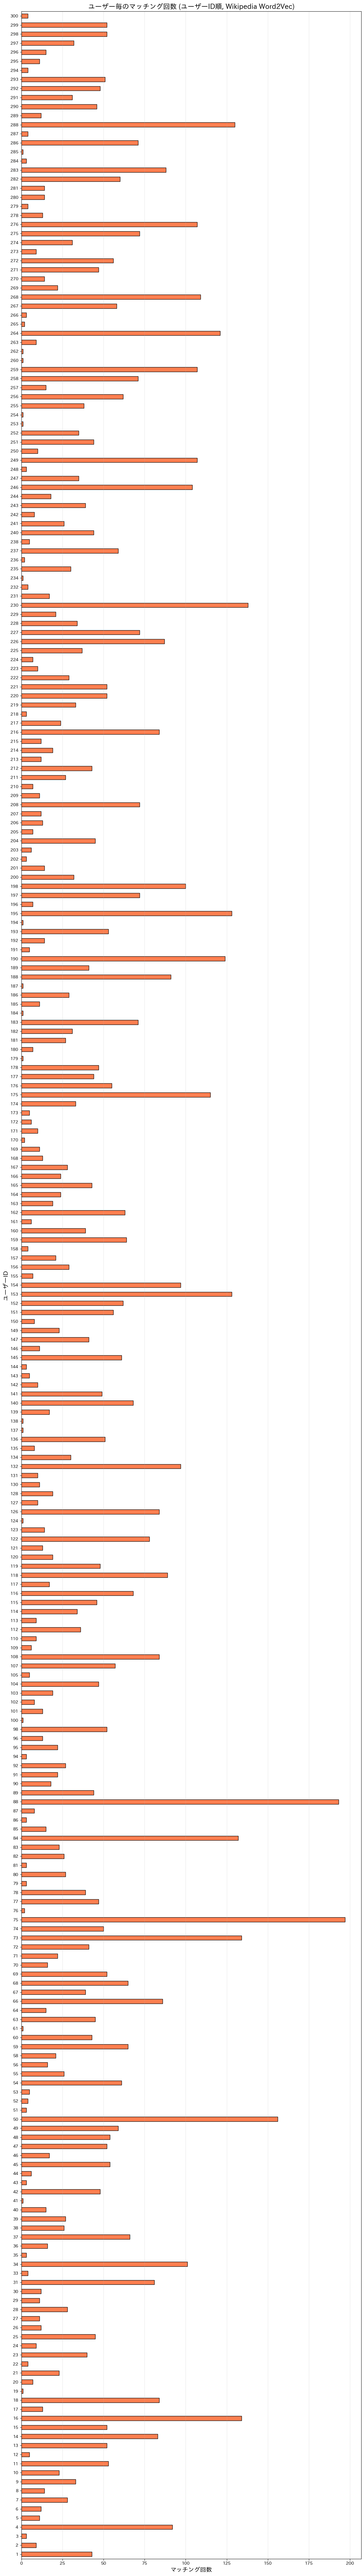

In [19]:
# ユーザー毎のマッチング回数を集計
user_match_counts = matching_results["user_id"].value_counts()

# ユーザーIDで昇順にソート
user_match_counts = user_match_counts.sort_index()

# 可視化
plt.rcParams["font.family"] = "IPAexGothic"
fig, ax = plt.subplots(figsize=(12, max(8, len(user_match_counts) * 0.3)))
user_match_counts.plot(kind="barh", ax=ax, color="coral", edgecolor="black")
ax.set_xlabel("マッチング回数", fontsize=14, fontweight="bold")
ax.set_ylabel("ユーザーID", fontsize=14, fontweight="bold")
ax.set_title(
    "ユーザー毎のマッチング回数 (ユーザーID順, Wikipedia Word2Vec)", fontsize=16, fontweight="bold"
)
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("../outputs/user_match_counts_wiki.png", dpi=300, bbox_inches="tight")
print("可視化を保存しました: ../outputs/user_match_counts_wiki.png")
plt.show()